# Bi-LSTM Method

### Task 1: Project Overview and Import Modules

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.10.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [14]:
data = pd.read_csv("E:\\NER_Project\\LSTM\\ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(26)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [15]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [16]:
words = list(set(data["Word"].values))
words

['Jays',
 'Swine',
 'skullcaps',
 'Shamin',
 'headline',
 'Jubilant',
 'Travel',
 'waving',
 '464',
 'understandable',
 'opium-producing',
 'nutrient',
 'jumps',
 'automotive',
 'Soviet-backed',
 'can',
 'Navarro-Valls',
 'war-weary',
 'longest-held',
 'commissioning',
 'wasteful',
 'environment-themed',
 '668',
 'Sisli',
 'Jonathan',
 'Harcharik',
 'intimidate',
 'layoffs',
 'weighs',
 'Creutzfeldt-Jakob',
 'Execution',
 'resisting',
 'incubator',
 'Repsol',
 'Nobel-Prize',
 'TAAF',
 'tracks',
 'Grigory',
 'modernization',
 'Anwarul',
 'Qais',
 'aspire',
 'Hunt',
 'schoolchildren',
 'Sunni-ruled',
 'Was',
 'Nenbutsushu',
 'quitting',
 'forcible',
 'Antananarivo',
 'Famed',
 'Fazlullah',
 'crazy',
 'Literature',
 'frank',
 'Shawal',
 'slumps',
 'Patriotic',
 'Body',
 'mixture',
 'compliments',
 'harming',
 'rival',
 'left-footed',
 'Electoral',
 'monarchy',
 'cites',
 'professors',
 'finalists',
 'Burundian',
 'Mushtaq',
 'imminent',
 'Tupamaros',
 'Herb',
 'Co',
 'slumped',
 'taint',


In [17]:
data['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [18]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [19]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [20]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [21]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [22]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [23]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [24]:
len(word2idx)

35179

In [25]:
tag2idx

{'I-geo': 0,
 'B-org': 1,
 'B-per': 2,
 'B-geo': 3,
 'B-nat': 4,
 'B-gpe': 5,
 'O': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-per': 9,
 'I-nat': 10,
 'I-art': 11,
 'I-org': 12,
 'I-tim': 13,
 'I-eve': 14,
 'B-eve': 15,
 'I-gpe': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

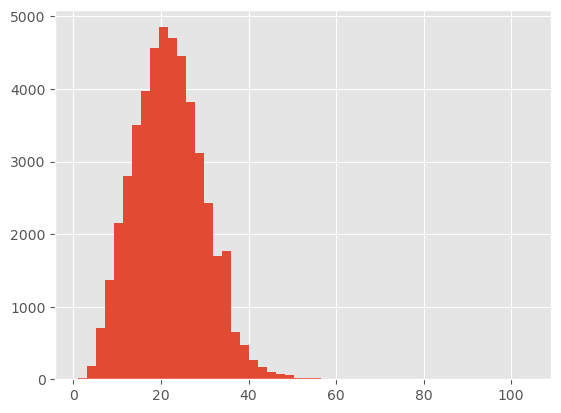

In [26]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [29]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [30]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [31]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

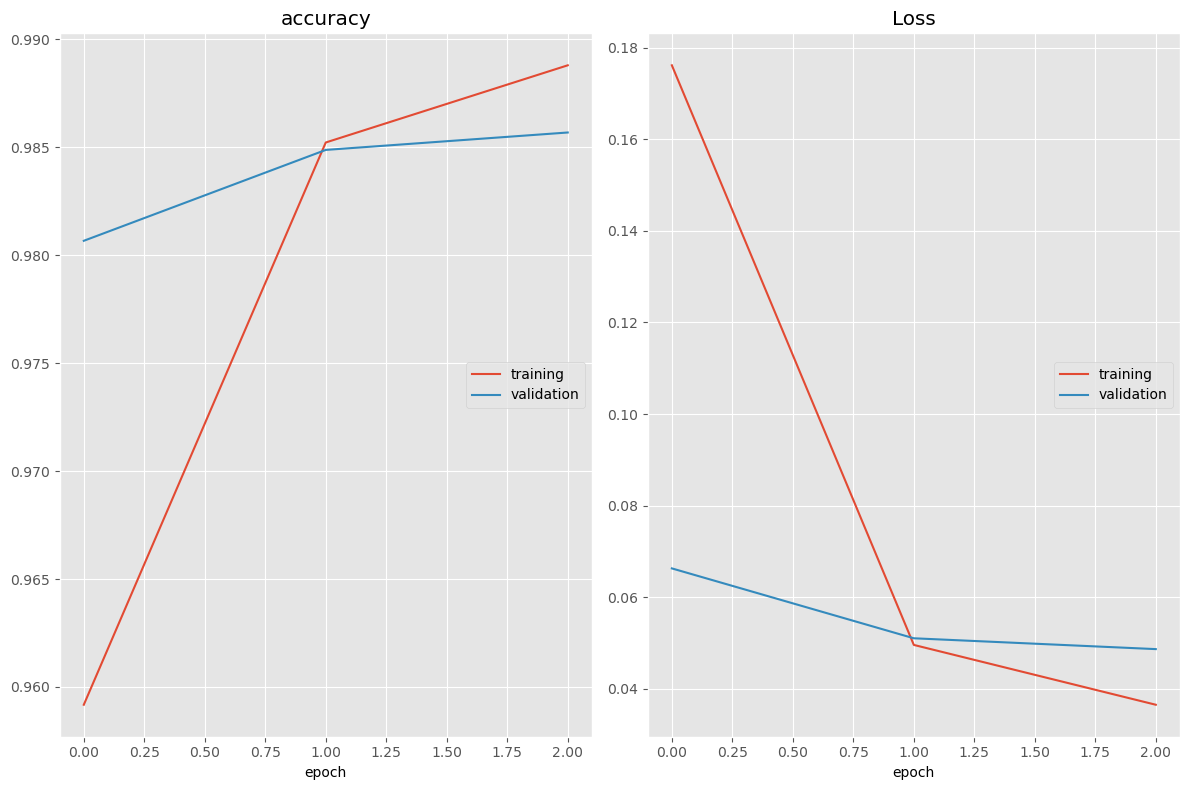

accuracy
	training         	 (min:    0.959, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.037, max:    0.176, cur:    0.037)
	validation       	 (min:    0.049, max:    0.066, cur:    0.049)

Epoch 3: val_loss improved from 0.05103 to 0.04866, saving model to model_weights.h5
1199/1199 [==============================] - 354s 295ms/step - loss: 0.0365 - accuracy: 0.9888 - val_loss: 0.0487 - val_accuracy: 0.9857
CPU times: total: 1h 49min 54s
Wall time: 23min 49s


In [33]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [34]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 16s 54ms/step - loss: 0.0487 - accuracy: 0.9857


[0.048661135137081146, 0.9856860041618347]

In [35]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 944ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election    O	O
By-election  